In [1]:
# Dependencies
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
from tensorflow.keras import layers

import random
import sys
import time

from tensorflow.keras import utils
from tensorflow.keras import preprocessing
from os import listdir
from os.path import isdir, join

import numpy as np
import matplotlib.pyplot as plt

# Reproduction
seed = 333
np.random.seed(seed)

### Data processing

In [2]:
from os.path import join
project_path = r"C:\Users\ktub2\Dropbox\family\Kausthubh\UW Madison\Coursework\ECE 539\Project"

In [3]:
omni_path = join(project_path, r"omniglot-processed-train")
omni_train_datasets = dict()
omni_val_datasets = dict()

for name in listdir(omni_path):
    path = join(omni_path, name)
    if isdir(path):
        omni_train_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.25, subset="training")
        omni_val_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.25, subset="validation")

Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for validation.
Found 400 files belonging to 20 classes.
Using 300 files for training.
Found 400 files belonging to 20 classes.
Using 100 files for vali

In [4]:
def dataset_to_tensors(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.extend(x)
        ys.extend(y)
    # xs = np.array(xs)
    # ys = np.array(ys)
    return tf.convert_to_tensor(xs), tf.convert_to_tensor(ys)

xs, ys = dataset_to_tensors(omni_val_datasets['Grantha'])
print(xs.shape, ys.shape)

(100, 28, 28, 1) (100, 20)


In [5]:
omni_train_data = []
omni_train_labels = []
omni_val_data = []
omni_val_labels = []
for i in omni_train_datasets.keys():
    xs,ys = dataset_to_tensors(omni_train_datasets[i])
    omni_train_data.append(xs)
    omni_train_labels.append(ys)
    print('Train dataset converted')
    xs,ys = dataset_to_tensors(omni_val_datasets[i])
    omni_val_data.append(xs)
    omni_val_labels.append(ys)
    print('Val dataset converted')

Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val dataset converted
Train dataset converted
Val datase

In [6]:
complete_datasets = []
for i in range(len(omni_train_data)):
    if(len(omni_val_data[i]) == 100):
        complete_datasets.append( (omni_train_data[i],omni_train_labels[i],omni_val_data[i],omni_val_labels[i]) )

### Model definition and relevant functions

In [24]:
def create_model():
    relu_initializer = tf.keras.initializers.HeNormal()
    softmax_initializer = tf.keras.initializers.GlorotNormal()
    
    inputs = keras.Input(shape=(28,28,1))
    for i in range(4):
        if(i == 0):
            x = layers.Conv2D(64, (3,3), kernel_initializer=relu_initializer, bias_initializer='zeros', 
                              activation='relu', padding='same')(inputs)
        else:
            x = layers.Conv2D(64, (3,3), kernel_initializer=relu_initializer, bias_initializer='zeros', 
                              activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPool2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(20, kernel_initializer=softmax_initializer)(x)
    outputs = layers.Softmax()(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='maml_model')
    return model

In [25]:
def compute_loss(model, x, y, loss_fn=keras.losses.CategoricalCrossentropy()):
    logits = model(x)
    loss = loss_fn(y, logits)
    return loss

In [26]:
meow = create_model()
meow.summary()

Model: "maml_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_34 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
batch_normalization_35 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 7, 7, 64)          0

### Meta Learning

In [43]:
lr = 0.001
alpha = 0.1
num_tasks = 15
epochs = 1000
inner_epochs = 3
i = 0
all_losses = []
optimizer_inner = keras.optimizers.SGD(learning_rate=alpha)
optimizer_outer = keras.optimizers.Adam(learning_rate=lr)

model = create_model()
model.compile()

for epoch in range(epochs):
    all_meta_gradients = []
    total_loss = 0
    
    for task in random.sample(complete_datasets,num_tasks):
        train_data, train_labels, test_data, test_labels = task
        
        with tf.GradientTape() as test_tape:
            model_copy = create_model()
            model_copy.set_weights(model.get_weights())
            model_copy.compile(optimizer=optimizer_inner, loss=tf.keras.losses.CategoricalCrossentropy())
            inner_history = model_copy.fit(train_data, train_labels, epochs=inner_epochs, verbose=0)
            test_loss = compute_loss(model_copy, test_data, test_labels)
            total_loss += test_loss
            i += 1
        print('.',end='')
        meta_gradients = test_tape.gradient(test_loss, model_copy.trainable_weights)
        all_meta_gradients.append(meta_gradients)
      
    print('')
    print('Gradient check: '+str(all_meta_gradients[0][0][0,0,0,0].numpy()))
    sum_meta_gradients = all_meta_gradients[0]
    for i in range(1,len(all_meta_gradients)):
        for j in range(len(all_meta_gradients[i])):
            sum_meta_gradients[j] = sum_meta_gradients[j] + all_meta_gradients[i][j]
    optimizer_outer.apply_gradients(zip(sum_meta_gradients, model.trainable_weights))
    
    print('Meta Update: Epoch Number '+str(epoch))
    print('Avg. Loss: '+str(total_loss/(i)))
    all_losses.append(total_loss/(i))

...............
Gradient check: -0.03458849
Meta Update: Epoch Number 0
Avg. Loss: tf.Tensor(11.768156, shape=(), dtype=float32)
...............
Gradient check: 0.096850455
Meta Update: Epoch Number 1
Avg. Loss: tf.Tensor(10.148666, shape=(), dtype=float32)
...............
Gradient check: -0.16864255
Meta Update: Epoch Number 2
Avg. Loss: tf.Tensor(9.214113, shape=(), dtype=float32)
...............
Gradient check: 0.052750584
Meta Update: Epoch Number 3
Avg. Loss: tf.Tensor(7.057494, shape=(), dtype=float32)
...............
Gradient check: 0.3940752
Meta Update: Epoch Number 4
Avg. Loss: tf.Tensor(6.115264, shape=(), dtype=float32)
...............
Gradient check: 0.22535303
Meta Update: Epoch Number 5
Avg. Loss: tf.Tensor(5.052243, shape=(), dtype=float32)
...............
Gradient check: -0.044938713
Meta Update: Epoch Number 6
Avg. Loss: tf.Tensor(4.520511, shape=(), dtype=float32)
...............
Gradient check: 0.015853062
Meta Update: Epoch Number 7
Avg. Loss: tf.Tensor(3.9052188, 

...............
Gradient check: 0.15215169
Meta Update: Epoch Number 64
Avg. Loss: tf.Tensor(2.2533376, shape=(), dtype=float32)
...............
Gradient check: -0.029443223
Meta Update: Epoch Number 65
Avg. Loss: tf.Tensor(2.005256, shape=(), dtype=float32)
...............
Gradient check: -0.009597369
Meta Update: Epoch Number 66
Avg. Loss: tf.Tensor(2.0371535, shape=(), dtype=float32)
...............
Gradient check: -0.026874531
Meta Update: Epoch Number 67
Avg. Loss: tf.Tensor(2.1632466, shape=(), dtype=float32)
...............
Gradient check: 0.038551472
Meta Update: Epoch Number 68
Avg. Loss: tf.Tensor(2.0988662, shape=(), dtype=float32)
...............
Gradient check: -0.04331421
Meta Update: Epoch Number 69
Avg. Loss: tf.Tensor(2.0558014, shape=(), dtype=float32)
...............
Gradient check: 0.027935423
Meta Update: Epoch Number 70
Avg. Loss: tf.Tensor(2.2263865, shape=(), dtype=float32)
...............
Gradient check: 0.03665677
Meta Update: Epoch Number 71
Avg. Loss: tf.Ten

...............
Gradient check: 0.050290592
Meta Update: Epoch Number 127
Avg. Loss: tf.Tensor(1.1701012, shape=(), dtype=float32)
...............
Gradient check: -0.026800644
Meta Update: Epoch Number 128
Avg. Loss: tf.Tensor(1.1653224, shape=(), dtype=float32)
...............
Gradient check: 0.0019288356
Meta Update: Epoch Number 129
Avg. Loss: tf.Tensor(1.2719198, shape=(), dtype=float32)
...............
Gradient check: 0.029196722
Meta Update: Epoch Number 130
Avg. Loss: tf.Tensor(1.2339584, shape=(), dtype=float32)
...............
Gradient check: -0.026173715
Meta Update: Epoch Number 131
Avg. Loss: tf.Tensor(1.5740852, shape=(), dtype=float32)
...............
Gradient check: 0.012598605
Meta Update: Epoch Number 132
Avg. Loss: tf.Tensor(1.0285289, shape=(), dtype=float32)
...............
Gradient check: 0.01708674
Meta Update: Epoch Number 133
Avg. Loss: tf.Tensor(1.1941475, shape=(), dtype=float32)
...............
Gradient check: -0.033702236
Meta Update: Epoch Number 134
Avg. L

...............
Gradient check: 0.03369949
Meta Update: Epoch Number 190
Avg. Loss: tf.Tensor(0.7741718, shape=(), dtype=float32)
...............
Gradient check: -0.050437298
Meta Update: Epoch Number 191
Avg. Loss: tf.Tensor(0.8429472, shape=(), dtype=float32)
...............
Gradient check: 0.023719495
Meta Update: Epoch Number 192
Avg. Loss: tf.Tensor(0.8188035, shape=(), dtype=float32)
...............
Gradient check: -0.010344397
Meta Update: Epoch Number 193
Avg. Loss: tf.Tensor(0.867486, shape=(), dtype=float32)
...............
Gradient check: 0.038854778
Meta Update: Epoch Number 194
Avg. Loss: tf.Tensor(0.7130238, shape=(), dtype=float32)
...............
Gradient check: 0.008682287
Meta Update: Epoch Number 195
Avg. Loss: tf.Tensor(0.73883635, shape=(), dtype=float32)
...............
Gradient check: 0.0037194244
Meta Update: Epoch Number 196
Avg. Loss: tf.Tensor(0.8277493, shape=(), dtype=float32)
...............
Gradient check: 0.0052182814
Meta Update: Epoch Number 197
Avg. L

KeyboardInterrupt: 

In [50]:
model.save_weights('saved_models/weights_maml_model')
model.save('saved_models/full_maml_model')

INFO:tensorflow:Assets written to: saved_models/full_maml_model\assets


Text(0.5, 1.0, 'Loss VS Epochs for 20-way classification')

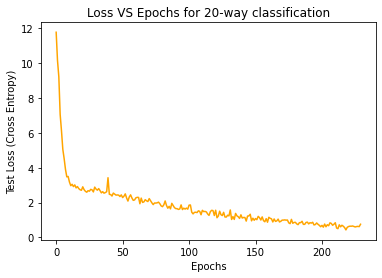

In [83]:
plt.plot(all_losses, 'orange')
plt.xlabel('Epochs')
plt.ylabel('Test Loss (Cross Entropy)')
plt.title('Loss VS Epochs for 20-way classification')

## Fine-tuning

In [33]:
omni_test_path = join(project_path, r"omniglot-processed-test")
omni_test_train_datasets = dict()
omni_test_val_datasets = dict()

for name in listdir(omni_test_path):
    path = join(omni_test_path, name)
    if isdir(path):
        omni_test_train_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.75, subset="training")
        omni_test_val_datasets[name] = preprocessing.image_dataset_from_directory(path, label_mode='categorical',
                                                             color_mode='grayscale', batch_size=1000, image_size=(28,28),
                                                             seed=seed, validation_split=0.75, subset="validation")

Found 400 files belonging to 20 classes.
Using 100 files for training.
Found 400 files belonging to 20 classes.
Using 300 files for validation.
Found 400 files belonging to 20 classes.
Using 100 files for training.
Found 400 files belonging to 20 classes.
Using 300 files for validation.
Found 400 files belonging to 20 classes.
Using 100 files for training.
Found 400 files belonging to 20 classes.
Using 300 files for validation.


In [34]:
omni_test_train_data = []
omni_test_train_labels = []
omni_test_val_data = []
omni_test_val_labels = []

for i in omni_test_train_datasets.keys():
    xs,ys = dataset_to_tensors(omni_test_train_datasets[i])
    omni_test_train_data.append(xs)
    omni_test_train_labels.append(ys)
    print('Test train dataset converted')
    xs,ys = dataset_to_tensors(omni_test_val_datasets[i])
    omni_test_val_data.append(xs)
    omni_test_val_labels.append(ys)
    print('Test val dataset converted')

Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted
Test train dataset converted
Test val dataset converted


In [103]:
greek_fine_tuning_data = omni_test_train_data[0]
greek_fine_tuning_labels = omni_test_train_labels[0]

greek_val_data = omni_test_val_data[0]
greek_val_labels = omni_test_val_labels[0]

# model_greek = create_model()
# model_greek.set_weights(model.get_weights())

In [104]:
model_greek = keras.models.load_model('saved_models/full_maml_model')

In [105]:
model_greek.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
model_greek.fit(greek_fine_tuning_data, greek_fine_tuning_labels, epochs=200, verbose=2)

Epoch 1/200
4/4 - 1s - loss: 5.1577 - accuracy: 0.0700
Epoch 2/200
4/4 - 1s - loss: 2.2454 - accuracy: 0.4800
Epoch 3/200
4/4 - 1s - loss: 1.2396 - accuracy: 0.7000
Epoch 4/200
4/4 - 1s - loss: 0.7010 - accuracy: 0.8800
Epoch 5/200
4/4 - 1s - loss: 0.4208 - accuracy: 0.9700
Epoch 6/200
4/4 - 1s - loss: 0.2428 - accuracy: 0.9900
Epoch 7/200
4/4 - 1s - loss: 0.1775 - accuracy: 1.0000
Epoch 8/200
4/4 - 1s - loss: 0.1337 - accuracy: 1.0000
Epoch 9/200
4/4 - 1s - loss: 0.1057 - accuracy: 0.9900
Epoch 10/200
4/4 - 1s - loss: 0.0689 - accuracy: 1.0000
Epoch 11/200
4/4 - 1s - loss: 0.0674 - accuracy: 1.0000
Epoch 12/200
4/4 - 1s - loss: 0.0631 - accuracy: 1.0000
Epoch 13/200
4/4 - 1s - loss: 0.0444 - accuracy: 1.0000
Epoch 14/200
4/4 - 1s - loss: 0.0460 - accuracy: 1.0000
Epoch 15/200
4/4 - 1s - loss: 0.0370 - accuracy: 1.0000
Epoch 16/200
4/4 - 1s - loss: 0.0335 - accuracy: 1.0000
Epoch 17/200
4/4 - 1s - loss: 0.0233 - accuracy: 1.0000
Epoch 18/200
4/4 - 1s - loss: 0.0207 - accuracy: 1.0000
E

4/4 - 1s - loss: 6.5829e-04 - accuracy: 1.0000
Epoch 145/200
4/4 - 1s - loss: 7.5848e-04 - accuracy: 1.0000
Epoch 146/200
4/4 - 1s - loss: 0.0010 - accuracy: 1.0000
Epoch 147/200
4/4 - 1s - loss: 6.7341e-04 - accuracy: 1.0000
Epoch 148/200
4/4 - 1s - loss: 7.5081e-04 - accuracy: 1.0000
Epoch 149/200
4/4 - 1s - loss: 5.6889e-04 - accuracy: 1.0000
Epoch 150/200
4/4 - 1s - loss: 7.1217e-04 - accuracy: 1.0000
Epoch 151/200
4/4 - 1s - loss: 6.4164e-04 - accuracy: 1.0000
Epoch 152/200
4/4 - 1s - loss: 5.4024e-04 - accuracy: 1.0000
Epoch 153/200
4/4 - 1s - loss: 5.1198e-04 - accuracy: 1.0000
Epoch 154/200
4/4 - 1s - loss: 5.4372e-04 - accuracy: 1.0000
Epoch 155/200
4/4 - 1s - loss: 5.9746e-04 - accuracy: 1.0000
Epoch 156/200
4/4 - 1s - loss: 5.3436e-04 - accuracy: 1.0000
Epoch 157/200
4/4 - 1s - loss: 5.3881e-04 - accuracy: 1.0000
Epoch 158/200
4/4 - 1s - loss: 6.0385e-04 - accuracy: 1.0000
Epoch 159/200
4/4 - 1s - loss: 5.0873e-04 - accuracy: 1.0000
Epoch 160/200
4/4 - 1s - loss: 4.7645e-04 

In [106]:
model_greek.evaluate(greek_val_data, greek_val_labels)

10/10 [==============================] - 1s 91ms/step - loss: 1.6678 - accuracy: 0.5267


[1.6677799224853516, 0.5266666412353516]

In [107]:
model_greek_meow = create_model()
model_greek_meow.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                    loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
model_greek_meow.fit(greek_fine_tuning_data, greek_fine_tuning_labels, epochs=200, verbose=2)

Epoch 1/200
4/4 - 1s - loss: 4.1618 - accuracy: 0.0500
Epoch 2/200
4/4 - 1s - loss: 1.8089 - accuracy: 0.5600
Epoch 3/200
4/4 - 1s - loss: 1.1531 - accuracy: 0.7900
Epoch 4/200
4/4 - 1s - loss: 0.7663 - accuracy: 0.8900
Epoch 5/200
4/4 - 1s - loss: 0.5411 - accuracy: 0.9700
Epoch 6/200
4/4 - 1s - loss: 0.3651 - accuracy: 0.9900
Epoch 7/200
4/4 - 1s - loss: 0.2457 - accuracy: 0.9900
Epoch 8/200
4/4 - 1s - loss: 0.1418 - accuracy: 1.0000
Epoch 9/200
4/4 - 1s - loss: 0.0916 - accuracy: 1.0000
Epoch 10/200
4/4 - 1s - loss: 0.0718 - accuracy: 1.0000
Epoch 11/200
4/4 - 1s - loss: 0.0466 - accuracy: 1.0000
Epoch 12/200
4/4 - 1s - loss: 0.0349 - accuracy: 1.0000
Epoch 13/200
4/4 - 1s - loss: 0.0243 - accuracy: 1.0000
Epoch 14/200
4/4 - 1s - loss: 0.0180 - accuracy: 1.0000
Epoch 15/200
4/4 - 1s - loss: 0.0168 - accuracy: 1.0000
Epoch 16/200
4/4 - 1s - loss: 0.0156 - accuracy: 1.0000
Epoch 17/200
4/4 - 1s - loss: 0.0128 - accuracy: 1.0000
Epoch 18/200
4/4 - 1s - loss: 0.0118 - accuracy: 1.0000
E

Epoch 147/200
4/4 - 1s - loss: 0.0032 - accuracy: 1.0000
Epoch 148/200
4/4 - 1s - loss: 0.0044 - accuracy: 1.0000
Epoch 149/200
4/4 - 1s - loss: 0.0048 - accuracy: 1.0000
Epoch 150/200
4/4 - 1s - loss: 0.0035 - accuracy: 1.0000
Epoch 151/200
4/4 - 1s - loss: 0.0028 - accuracy: 1.0000
Epoch 152/200
4/4 - 1s - loss: 0.0031 - accuracy: 1.0000
Epoch 153/200
4/4 - 1s - loss: 0.0033 - accuracy: 1.0000
Epoch 154/200
4/4 - 1s - loss: 0.0023 - accuracy: 1.0000
Epoch 155/200
4/4 - 1s - loss: 0.0026 - accuracy: 1.0000
Epoch 156/200
4/4 - 1s - loss: 0.0035 - accuracy: 1.0000
Epoch 157/200
4/4 - 1s - loss: 0.0021 - accuracy: 1.0000
Epoch 158/200
4/4 - 1s - loss: 0.0017 - accuracy: 1.0000
Epoch 159/200
4/4 - 1s - loss: 0.0018 - accuracy: 1.0000
Epoch 160/200
4/4 - 1s - loss: 0.0015 - accuracy: 1.0000
Epoch 161/200
4/4 - 1s - loss: 0.0021 - accuracy: 1.0000
Epoch 162/200
4/4 - 1s - loss: 0.0012 - accuracy: 1.0000
Epoch 163/200
4/4 - 1s - loss: 0.0035 - accuracy: 1.0000
Epoch 164/200
4/4 - 1s - loss: 

In [108]:
model_greek_meow.evaluate(greek_val_data, greek_val_labels)

10/10 [==============================] - 2s 151ms/step - loss: 2.8423 - accuracy: 0.3533


[2.842278242111206, 0.35333332419395447]